In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import seaborn as sn
import numpy as np
import joblib    
import pickle
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNELS=3
EPOCHS=30

In [3]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "D:\Ishita\IGDTUW (CSE)\Summer Internship 2023\PlantVillage",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [4]:
class_names=dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
len(dataset)

68

(32, 256, 256, 3)
[0 1 1 1 0 1 0 1 1 1 1 0 2 1 1 0 1 2 1 0 0 1 0 1 1 0 0 0 0 0 1 1]


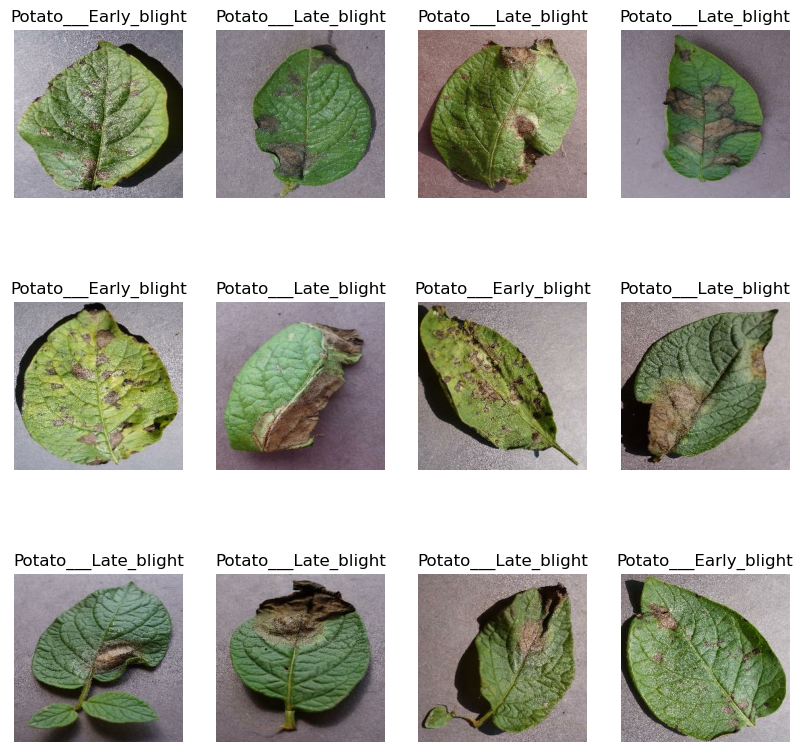

In [6]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [7]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size=len(ds)
    if shuffle:
        ds=ds.shuffle(shuffle_size, seed=12)
    train_size=int(train_split*ds_size)
    val_size=int(val_split*ds_size)
    train_ds=ds.take(train_size)
    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)
    return train_ds, val_ds, test_ds
train_ds, val_ds, test_ds=get_dataset_partitions_tf(dataset)

In [8]:
print(len(train_ds), len(val_ds), len(test_ds))

54 6 8


In [9]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [10]:
resize_and_rescale=tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])
data_augmentation=tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [11]:
input_shape=(BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes=3
model=models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])
model.build(input_shape=input_shape)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [12]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)
history=model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/30
54/54 [==============================] - 70s 1s/step - loss: 0.9064 - accuracy: 0.4832 - val_loss: 0.8613 - val_accuracy: 0.4583
Epoch 2/30
54/54 [==============================] - 69s 1s/step - loss: 0.8312 - accuracy: 0.5885 - val_loss: 0.8204 - val_accuracy: 0.6406
Epoch 3/30
54/54 [==============================] - 69s 1s/step - loss: 0.5814 - accuracy: 0.7471 - val_loss: 0.5432 - val_accuracy: 0.7240
Epoch 4/30
54/54 [==============================] - 69s 1s/step - loss: 0.3166 - accuracy: 0.8767 - val_loss: 0.2526 - val_accuracy: 0.8854
Epoch 5/30
54/54 [==============================] - 83s 2s/step - loss: 0.2512 - accuracy: 0.8981 - val_loss: 0.2248 - val_accuracy: 0.9115
Epoch 6/30
54/54 [==============================] - 68s 1s/step - loss: 0.2366 - accuracy: 0.9045 - val_loss: 0.6586 - val_accuracy: 0.7240
Epoch 7/30
54/54 [==============================] - 69s 1s/step - loss: 0.2360 - accuracy: 0.9051 - val_loss: 0.2188 - val_accuracy: 0.8958
Epoch 8/30
54/54 [==

In [13]:
scores=model.evaluate(test_ds)
scores

8/8 [==============================] - 3s 226ms/step - loss: 0.0283 - accuracy: 0.9844


[0.028254589065909386, 0.984375]

In [14]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [15]:
history.history['loss']

[0.9064315557479858,
 0.8311538696289062,
 0.5814330577850342,
 0.3166046738624573,
 0.2512352466583252,
 0.23657089471817017,
 0.2359652817249298,
 0.15664690732955933,
 0.15650242567062378,
 0.12305834889411926,
 0.09071438759565353,
 0.09900042414665222,
 0.08108372986316681,
 0.07910779118537903,
 0.09363748133182526,
 0.05646701157093048,
 0.07316753268241882,
 0.051758237183094025,
 0.08921799808740616,
 0.07011210173368454,
 0.0712910145521164,
 0.06846042722463608,
 0.08438894152641296,
 0.07302877306938171,
 0.048500653356313705,
 0.08976076543331146,
 0.047236986458301544,
 0.03788665309548378,
 0.06260615587234497,
 0.030862124636769295]

In [16]:
history.history['accuracy']

[0.48321759700775146,
 0.5885416865348816,
 0.7471064925193787,
 0.8767361044883728,
 0.8981481194496155,
 0.9045138955116272,
 0.9050925970077515,
 0.9334490895271301,
 0.9432870149612427,
 0.9525462985038757,
 0.9635416865348816,
 0.9623842835426331,
 0.9710648059844971,
 0.9728009104728699,
 0.9658564925193787,
 0.9785879850387573,
 0.9733796119689941,
 0.9809027910232544,
 0.9704861044883728,
 0.9733796119689941,
 0.9751157164573669,
 0.9762731194496155,
 0.9664351940155029,
 0.9739583134651184,
 0.9820601940155029,
 0.9658564925193787,
 0.9803240895271301,
 0.9866898059844971,
 0.9785879850387573,
 0.9907407164573669]

In [17]:
history.history['val_loss']

[0.861293613910675,
 0.8203946948051453,
 0.5431810021400452,
 0.25261056423187256,
 0.22476376593112946,
 0.6585534811019897,
 0.21881556510925293,
 0.19858922064304352,
 0.8701793551445007,
 0.5938753485679626,
 0.26066404581069946,
 0.67690509557724,
 0.08346647024154663,
 0.14461691677570343,
 0.11999122053384781,
 0.37132903933525085,
 0.062051620334386826,
 0.033262889832258224,
 0.09109378606081009,
 0.06577318161725998,
 0.07620216906070709,
 0.01888205111026764,
 0.5669071078300476,
 0.09760668128728867,
 0.048844557255506516,
 0.1272667497396469,
 0.046438466757535934,
 0.03274551406502724,
 0.10452466458082199,
 0.008602513931691647]

In [18]:
history.history['val_accuracy']

[0.4583333432674408,
 0.640625,
 0.7239583134651184,
 0.8854166865348816,
 0.9114583134651184,
 0.7239583134651184,
 0.8958333134651184,
 0.921875,
 0.7239583134651184,
 0.8072916865348816,
 0.9270833134651184,
 0.8229166865348816,
 0.96875,
 0.9427083134651184,
 0.9427083134651184,
 0.9010416865348816,
 0.9739583134651184,
 1.0,
 0.9635416865348816,
 0.9791666865348816,
 0.9791666865348816,
 1.0,
 0.7239583134651184,
 0.9635416865348816,
 0.984375,
 0.9479166865348816,
 0.9791666865348816,
 0.9895833134651184,
 0.9635416865348816,
 0.9947916865348816]

In [19]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

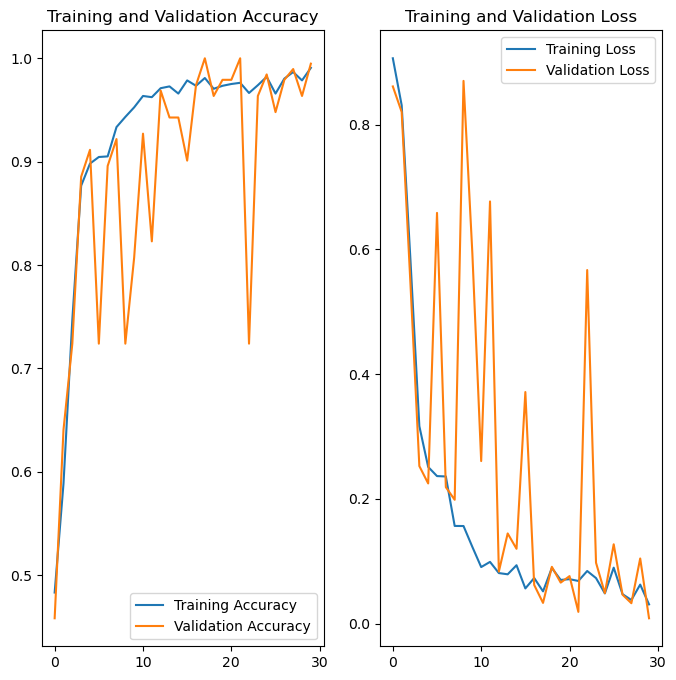

In [20]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

In [21]:
true_labels = []
pred_labels = []
for images_batch, labels_batch in test_ds.take(8):
    batch_prediction=model.predict(images_batch).argmax(axis=1)
    for i in labels_batch:
        true_labels.append(i)
    for i in batch_prediction:
        pred_labels.append(i)

1/1 [==============================] - 0s 251ms/step


In [22]:
def predict(model, img):
    img_array=tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array=tf.expand_dims(img_array,0)
    predictions=model.predict(img_array)
    predicted_class=class_names[np.argmax(predictions[0])]
    confidence=round(100*(np.max(predictions[0])),2)
    return predicted_class, confidence

1/1 [==============================] - 0s 42ms/step


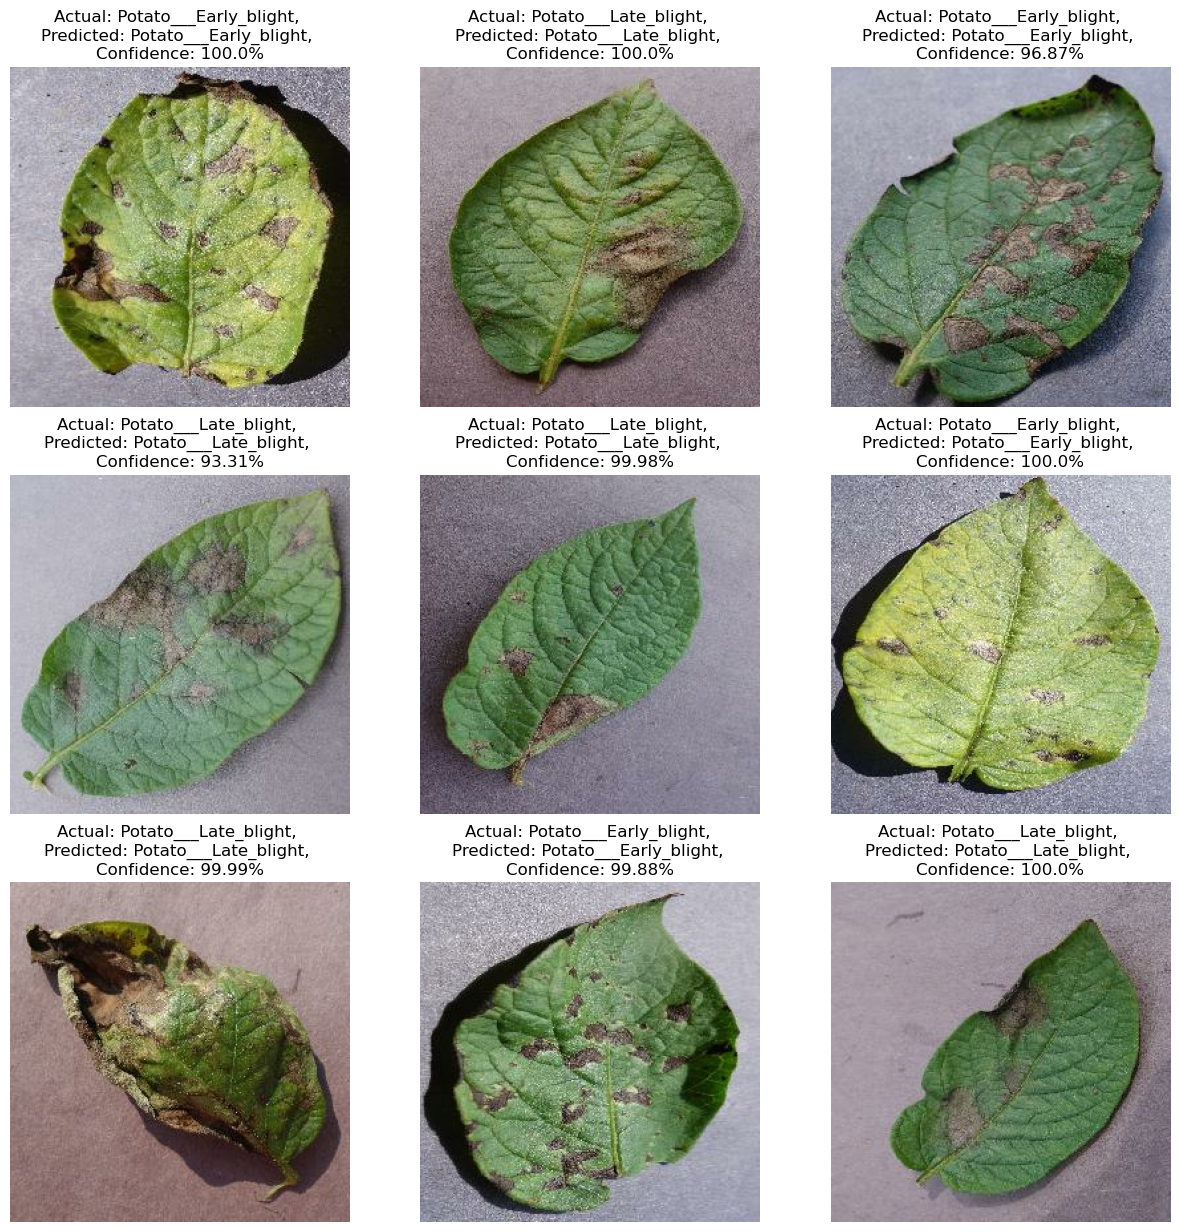

In [23]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence=predict(model,images[i].numpy())
        actual_class=class_names[labels[i]]
        plt.title(f"Actual: {actual_class}, \nPredicted: {predicted_class}, \nConfidence: {confidence}%")
        plt.axis("off")

In [24]:
print ("Classification Report: \n", classification_report(true_labels, pred_labels))

Classification Report: 
               precision    recall  f1-score   support

           0       1.00      0.99      1.00       110
           1       0.99      0.98      0.98       128
           2       0.86      1.00      0.92        18

    accuracy                           0.98       256
   macro avg       0.95      0.99      0.97       256
weighted avg       0.99      0.98      0.98       256



In [25]:
cm=tf.math.confusion_matrix(true_labels, pred_labels)
cm

<tf.Tensor: shape=(3, 3), dtype=int32, numpy=
array([[109,   1,   0],
       [  0, 125,   3],
       [  0,   0,  18]])>

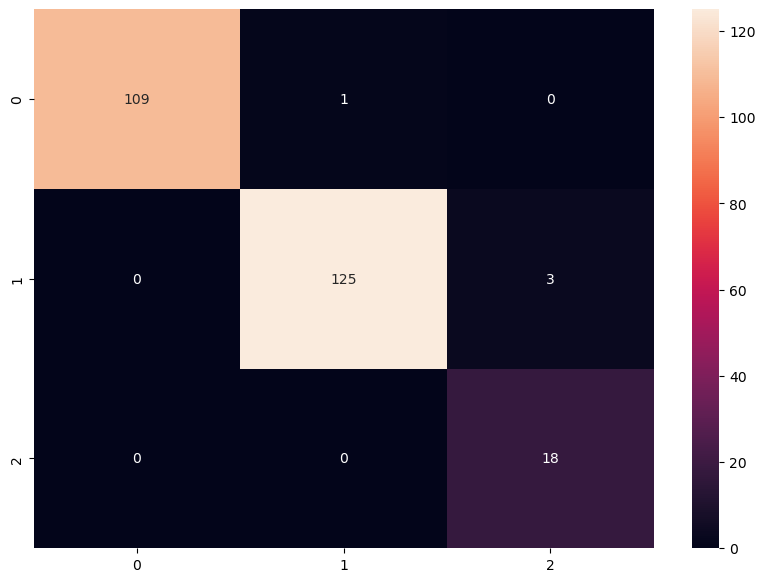

In [26]:
plt.figure(figsize=(10,7))
sn.heatmap(cm,annot=True,fmt='d')
plt.xlabel=('Predicted')
plt.ylabel=('Truth')

In [27]:
filename = "Model1-Epochs30.joblib"
joblib.dump(model, filename)

['Model1-Epochs30.joblib']